# Importing all necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "password",
                            database = "ecommerce")
cur = db.cursor()

## 1. List all unique cities where customers are located.

In [3]:
query = """ SELECT DISTINCT customer_city FROM customers """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## 2. Find the total sales per category

In [5]:
query2 = """ 
    SELECT 
        UPPER(products.product_category) AS category,
        ROUND(SUM(payments.payment_value), 2) AS sales
    FROM products 
    JOIN order_items
    ON products.product_id = order_items.product_id
    JOIN payments 
    ON payments.order_id = order_items.order_id
    GROUP BY category;
"""

cur.execute(query2)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "sales"])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


## 3. Count the number of orders placed in 2017.

In [7]:
query3 = """ 
    SELECT COUNT(order_id)
    FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2017
"""
cur.execute(query3)
data = cur.fetchall()

print(f"total orders placed in 2017 are {data[0][0]}")

total orders placed in 2017 are 45101


## 4. Calculate the percentage of orders that were paid in installments.

In [9]:
query4 = """ 
    SELECT 
        (SUM(
            CASE 
                WHEN payment_installments >= 1 THEN 1
                ELSE 0
            END
        ) / COUNT(*)) * 100 AS percentage_paid_installments
    FROM payments
"""
cur.execute(query4)
data = cur.fetchall()

print(f"the percentage of orders that were paid in installments is{data[0][0]}")

the percentage of orders that were paid in installments is99.9981


## 5. Count the number of customers from each state.

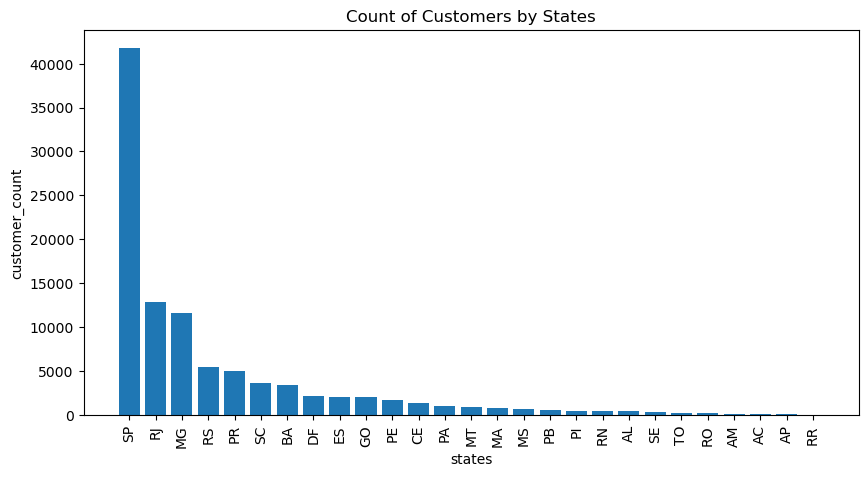

In [12]:
query5 = """ 
    SELECT 
        customer_state,
        COUNT(customer_id)
    FROM customers
    GROUP BY customer_state
    ORDER BY customer_state
"""
cur.execute(query5)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

# Plot
plt.figure(figsize = (10, 5))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)

# X and Y Label Name and Title
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

## 6. Calculate the number of orders per month in 2018.

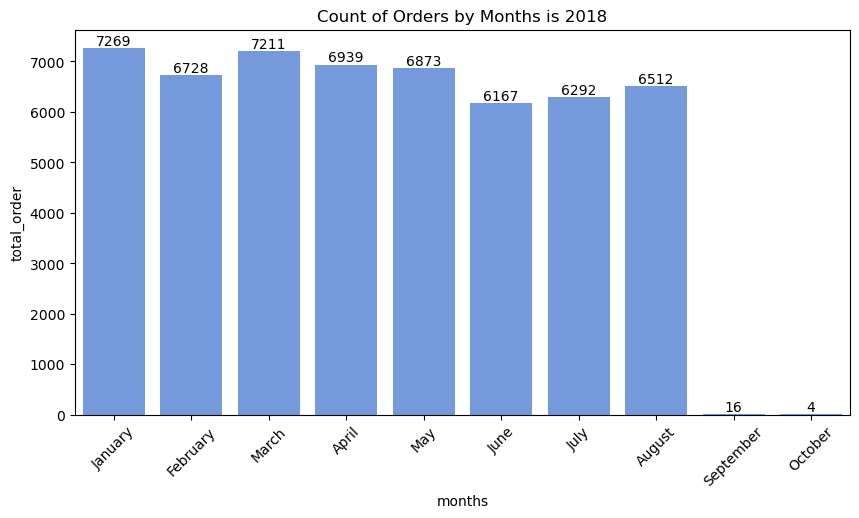

In [15]:
query6 = """ 
    SELECT 
        MONTHNAME(order_purchase_timestamp) AS months,
        COUNT(order_id) AS total_order
    FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2018
    GROUP BY months
"""

cur.execute(query6)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months", "total_order"])
o = ["January", "February","March","April","May","June","July","August","September","October"]
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = df["months"],y =  df["total_order"], data = df, order = o, color = "cornflowerblue")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.show()


## 7. Find the average number of products per order, grouped by customer city.

In [18]:
query7 = """ 
    with count_per_order as 
    (
    SELECT 
    	orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS oc
    FROM orders JOIN order_items
    ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
    )
    SELECT 
    	customers.customer_city, 
        ROUND(AVG(count_per_order.oc),2) AS average_orders
    FROM customers JOIN count_per_order
    ON customers.customer_id = count_per_order.customer_id
    GROUP BY customers.customer_city 
    ORDER BY average_orders DESC
"""

cur.execute(query7)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["customer_city", "average_orders"])
df = df.sort_values(by="average_orders", ascending=False).head(10)
df.head(10)

,customer_city,average_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


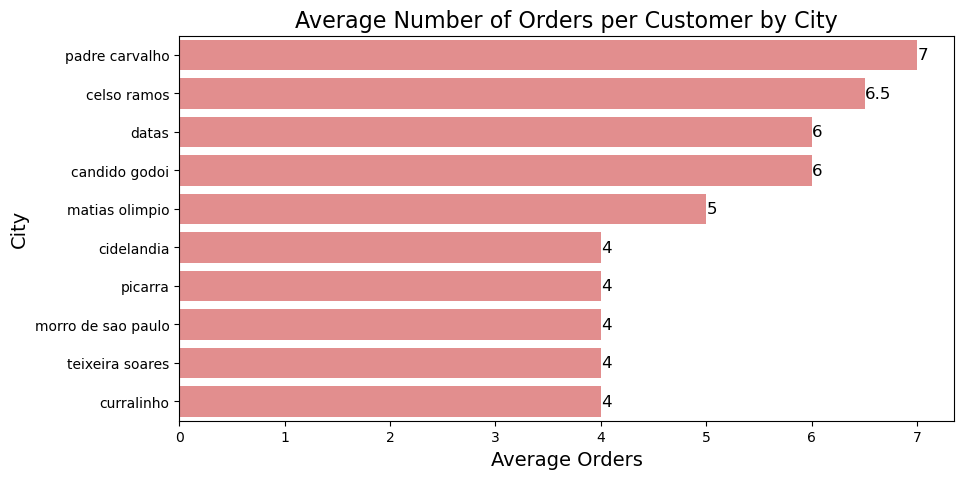

In [21]:
query7 = """ 
    with count_per_order as 
    (
    SELECT 
    	orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS oc
    FROM orders JOIN order_items
    ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
    )
    SELECT 
    	customers.customer_city, 
        ROUND(AVG(count_per_order.oc),2) AS average_orders
    FROM customers JOIN count_per_order
    ON customers.customer_id = count_per_order.customer_id
    GROUP BY customers.customer_city 
    ORDER BY average_orders DESC
"""

cur.execute(query7)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["customer_city", "average_orders"])
df = df.sort_values(by="average_orders", ascending=False).head(10)
df.head(10)
plt.figure(figsize=(10,5))
ax = sns.barplot(
    y="customer_city", 
    x="average_orders", 
    data=df, 
    color ="lightcoral"  # nice color gradient
)
ax.bar_label(ax.containers[0], fontsize=12)
plt.title("Average Number of Orders per Customer by City", fontsize=16)
plt.xlabel("Average Orders", fontsize=14)
plt.ylabel("City", fontsize=14)
plt.show()

## 8. Calculate the percentage of total revenue contributed by each product category.

In [25]:
query8 = """ 
    SELECT 
	UPPER(products.product_category) AS category, 
	ROUND((SUM(payments.payment_value)/
			(SELECT 
				SUM(payment_value) 
			FROM payments)
			) * 100, 2) AS sales_percentage
    FROM products JOIN order_items 
    ON products.product_id = order_items.product_id
    JOIN payments 
    ON payments.order_id = order_items.order_id
    GROUP BY category 
    ORDER BY sales_percentage DESC;
"""

cur.execute(query8)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["category", "sales_percentage"])
df = df.sort_values(by="sales_percentage", ascending=False)
df.head(20)


,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


## 9. Identify the correlation between product price and the number of times a product has been purchased.

In [27]:
import numpy as np

query9 = """
    SELECT 
        products.product_category AS category,
        COUNT(order_items.product_id) AS order_count,
        ROUND(AVG(order_items.price), 2) AS price
    FROM products 
    JOIN order_items
    ON products.product_id = order_items.product_id
    GROUP BY products.product_category
"""

cur.execute(query9)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print(f"The correlation is {a[0][-1]}")

The correlation is -0.10631514167157562


## 10. Calculate the total revenue generated by each seller, and rank them by revenue.

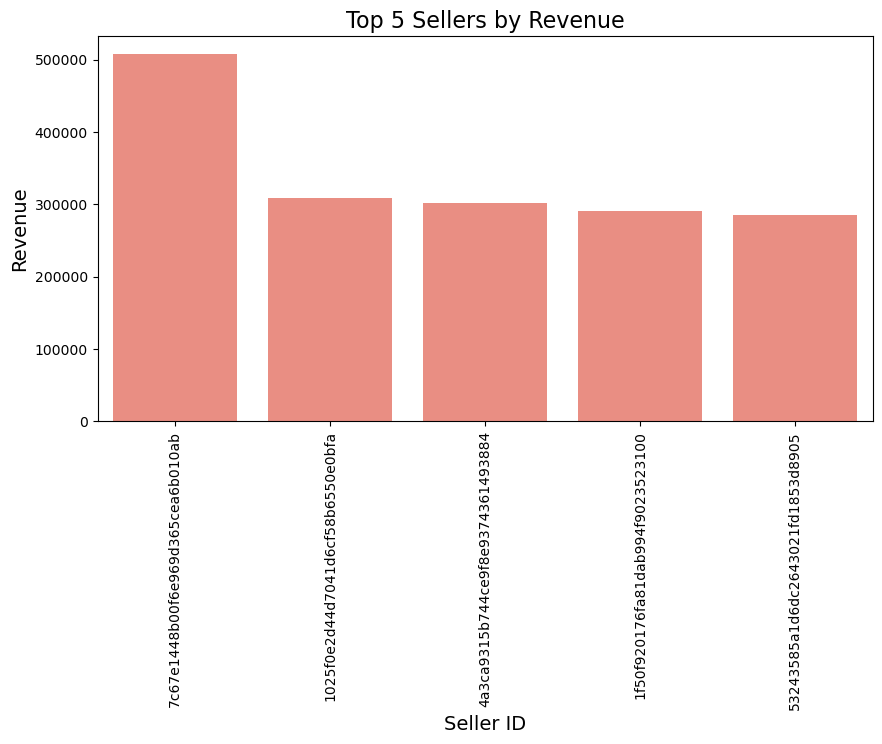

In [30]:
query10 = """ 
    SELECT
        *,
        DENSE_RANK() OVER(ORDER BY revenue DESC) AS rn
    FROM (
        SELECT
            order_items.seller_id AS sellerid,
            SUM(payments.payment_value) AS revenue
        FROM order_items
        JOIN payments
        ON order_items.order_id = payments.order_id
        GROUP BY order_items.seller_id
    ) AS a
"""

cur.execute(query10)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["sellerid", "revenue", "rank"])
df = df.sort_values(by="revenue", ascending=False).head()

plt.figure(figsize=(10,5))
sns.barplot(x="sellerid", y="revenue", data=df, color="salmon")
plt.xticks(rotation=90)
plt.title("Top 5 Sellers by Revenue", fontsize=16)
plt.xlabel("Seller ID", fontsize=14)
plt.ylabel("Revenue", fontsize=14)
plt.show()

## 11. Calculate the moving average of order values for each customer over their order history.

In [33]:
query11 = """
    SELECT 
        customer_id,
        order_purchase_timestamp,
        payment,
        avg(payment) over(partition by customer_id order by order_purchase_timestamp
        rows between 2 preceding and current row) as mov_avg
    FROM (
        SELECT
            orders.customer_id, 
            orders.order_purchase_timestamp, 
            payments.payment_value as payment
        FROM payments JOIN orders
        ON payments.order_id = orders.order_id
    ) AS a
"""

cur.execute(query11)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


## 12. Calculate the cumulative sales per month for each year.

In [36]:
query12 = """
    SELECT 
        years, 
        months, 
        payment, 
        SUM(payment) OVER(order by years, months) 
        cumulative_sales 
        FROM 
        (
            SELECT 
                year(orders.order_purchase_timestamp) as years,
                month(orders.order_purchase_timestamp) as months,
                round(sum(payments.payment_value),2) as payment 
            FROM orders JOIN payments
            ON orders.order_id = payments.order_id
            GROUP BY years, months 
            ORDER BY years, months
        ) as a
"""

cur.execute(query12)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


## 13. Calculate the year-over-year growth rate of total sales.

In [39]:
query13 = """
WITH payment_per_year AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS year,
        ROUND(SUM(payments.payment_value), 2) AS total_payment
    FROM orders
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY year
    ORDER BY year
)

SELECT 
    year,
    ROUND(
        ((total_payment - LAG(total_payment) OVER (ORDER BY year)) / 
         LAG(total_payment) OVER (ORDER BY year)) * 100, 
        2
    ) AS yoy_growth_percentage
FROM payment_per_year
"""

cur.execute(query13)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["year", "YoY Growth (%)"])
df

,year,YoY Growth (%)
0,2016,NaN
1,2017,12112.7
2,2018,20.0


## 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [43]:
query14 = """ 
WITH first_orders AS (
    SELECT
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order_date
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
next_orders_within_6_months AS (
    SELECT 
        customers.customer_id,
        COUNT(DISTINCT orders.order_id) AS next_orders_count
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    JOIN first_orders ON customers.customer_id = first_orders.customer_id
    WHERE orders.order_purchase_timestamp > first_orders.first_order_date
      AND orders.order_purchase_timestamp <= DATE_ADD(first_orders.first_order_date, INTERVAL 6 MONTH)
    GROUP BY customers.customer_id
)

SELECT
    ROUND(
        100 * COUNT(DISTINCT next_orders_within_6_months.customer_id) / COUNT(DISTINCT first_orders.customer_id),
        2
    ) AS repurchase_rate
FROM first_orders
LEFT JOIN next_orders_within_6_months
ON first_orders.customer_id = next_orders_within_6_months.customer_id

"""
cur.execute(query14)
data = cur.fetchall()
data

[(Decimal('0.00'),)]

## 15. Identify the top 3 customers who spent the most money in each year.

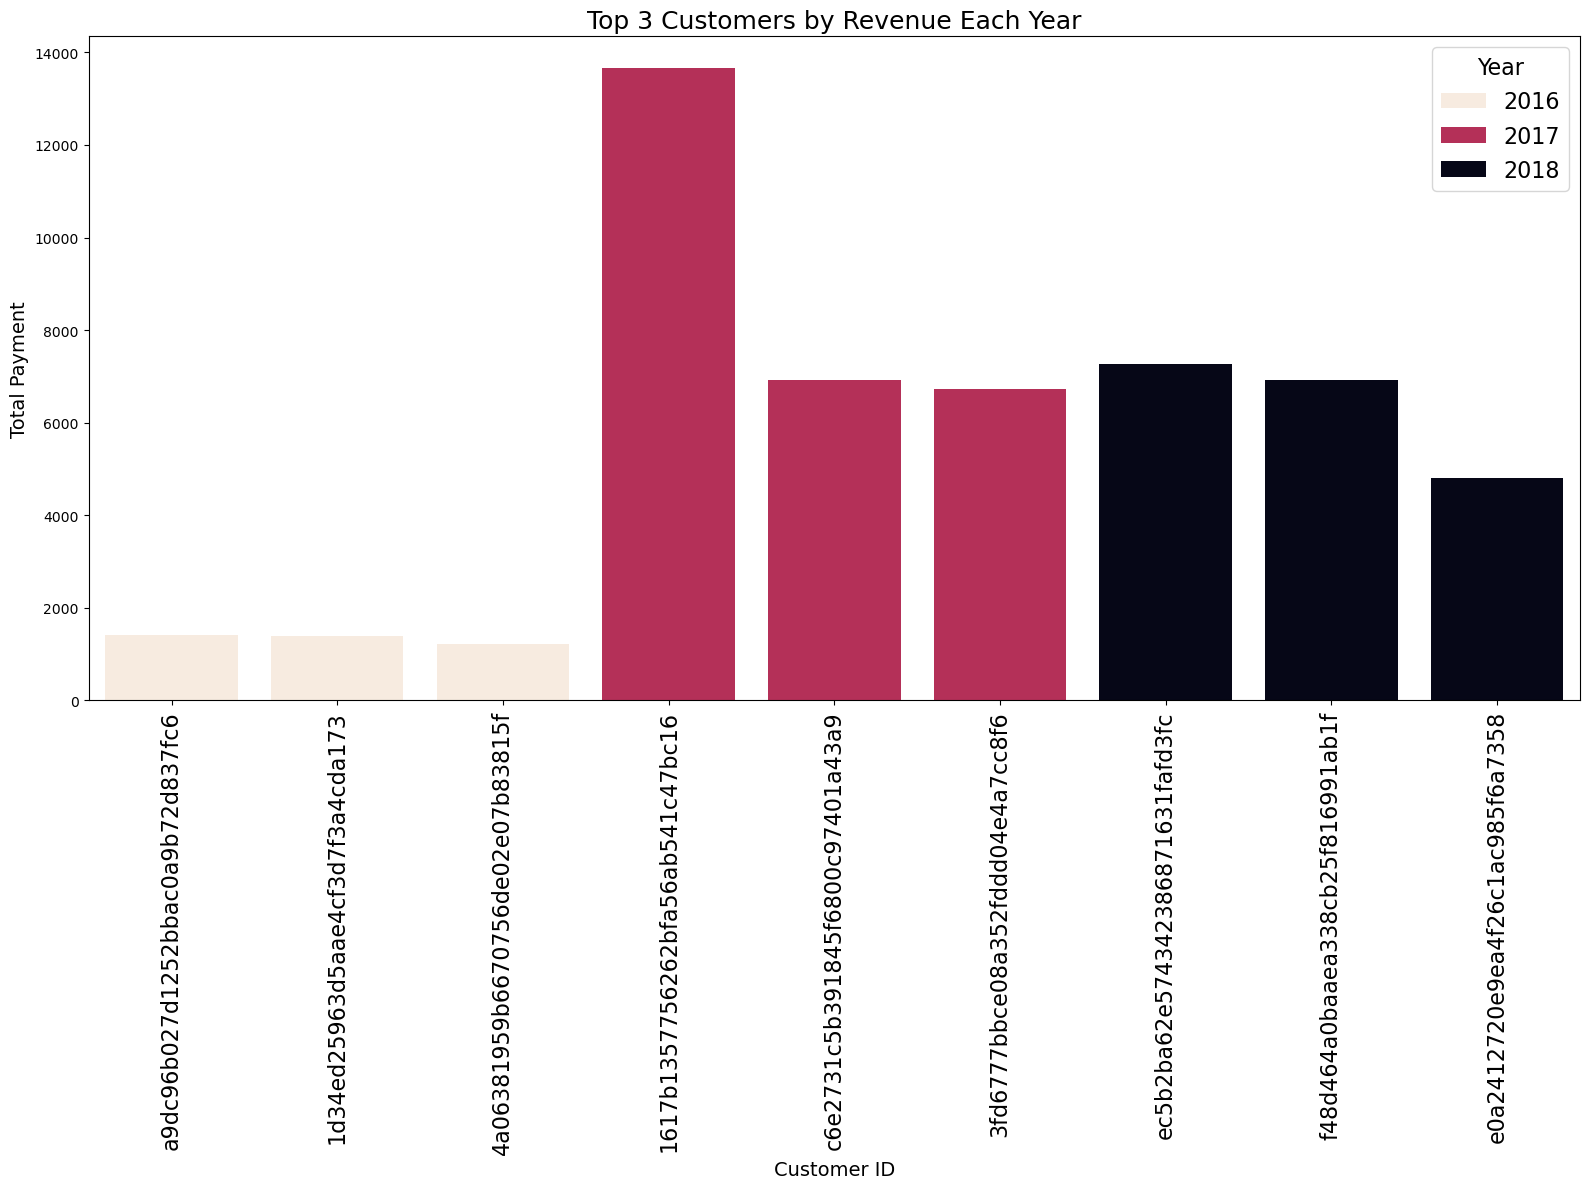

In [45]:
query15 = """
    WITH ranked_customers AS (
        SELECT 
            YEAR(orders.order_purchase_timestamp) AS years,
            orders.customer_id,
            SUM(payments.payment_value) AS total_payment,
            DENSE_RANK() OVER(
    			PARTITION BY YEAR(orders.order_purchase_timestamp) 
                ORDER BY SUM(payments.payment_value) DESC
    		) AS ranks
        FROM orders JOIN payments
        ON orders.order_id = payments.order_id
        GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
    )
    SELECT
        years,
        customer_id,
        total_payment,
        ranks
    FROM ranked_customers
    WHERE ranks <=3
    ORDER BY years, ranks
"""
cur.execute(query15)
data = cur.fetchall()


df = pd.DataFrame(data, columns=["years", "customer_id", "total_payment", "ranks"])
plt.figure(figsize=(16, 12))
sns.barplot(
    x="customer_id", 
    y="total_payment", 
    hue="years", 
    data=df, 
    palette="rocket_r"
)
plt.title("Top 3 Customers by Revenue Each Year", fontsize=18)
plt.xlabel("Customer ID", fontsize=14)
plt.ylabel("Total Payment", fontsize=14)
plt.xticks(rotation=90, fontsize=16)
plt.legend(title="Year", title_fontsize='16', fontsize='16')
plt.tight_layout()
plt.show()